In [1]:
#This notebook if for test and tunning - Reads the description from the description.txt file

In [2]:
import sys
import semantria
import time
import pandas as pd
import gender_guesser.detector as gender

# Consumer key and secret
consumerKey = "b28c7f8e-b506-4355-a484-6f77190eaad7"
consumerSecret = "0fbae06e-b8a5-4240-b0b1-2efaeb2db89b"

# Initializes new session with the keys.
session = semantria.Session(consumerKey, consumerSecret)
subscription = session.getSubscription()

gender_det = gender.Detector()

In [3]:
# Given a full name, guessGender returns girl, boy or none if gender is undefined 
def guessGender(name):
    first = name.split()[0]
    guess = gender_det.get_gender(first)
    if guess == "female" or guess == "mostly_female":
        return "girl"
    elif guess == "male" or guess == "mostly_male":
        return "boy"
    else:
        return None
    

In [16]:
#open and print the file Description
file = open("description.txt","r")
str_f = file.read()
file.close()
print(str_f)

Readers beware. The brilliant, breathtaking conclusion to J.K. Rowling's spellbinding series is not for the faint of heart--such revelations, battles, and betrayals await in Harry Potter and the Deathly Hallows that no fan will make it to the end unscathed. Luckily, Rowling has prepped loyal readers for the end of her series by doling out increasingly dark and dangerous tales of magic and mystery, shot through with lessons about honor and contempt, love and loss, and right and wrong. Fear not, you will find no spoilers in our review--to tell the plot would ruin the journey, and Harry Potter and the Deathly Hallows is an odyssey the likes of which Rowling's fans have not yet seen, and are not likely to forget. But we would be remiss if we did not offer one small suggestion before you embark on your final adventure with Harry--bring plenty of tissues.
The heart of Book 7 is a hero's mission--not just in Harry's quest for the Horcruxes, but in his journey from boy to man--and Harry faces 

In [17]:
#Create data for documents

#the document to send to semantria
documents = dict()
documents[0] = list()
documents[0].append({'id': str(0), 'text': str_f, "metadata": {"Author": "Author Sample", "Book Name": "Book name Sample"}})

In [18]:
#Send the Document
status = session.queueBatch(documents[0])
if status in [200, 202]:
    print ("{0} documents queued successfully.".format(len(documents[0])))
else:
    print("error in processing")
#After Sending, it is necessary to wait before retrieving. 5 seconds is a lot for this example, but will garantee the processing
time.sleep(5)

1 documents queued successfully.


In [19]:
#Retrieve the Documents
results = []
print ("Retrieving your processed results...")
response = session.getProcessedDocuments()
for item in response:
    results.append(item)

print("Done!")

Retrieving your processed results...
Done!


In [20]:
#Extract Character and Settings from the results
Character = dict()
Setting = dict()

CharDescrip = dict()
SetDescrip = dict()

results.sort(key = lambda x: (len (x['id']), x['id'])) 
for data in results:
    
    print ("Document {0} / Sentiment score: {1}".format(data['id'], data['sentiment_score']))
    print(data['metadata'])
    first, *middle, last = data['metadata']['Author'].split()
    author = last

    if "entities" in data:
        for entity in data["entities"]: 
            if((entity['type'] == 'user' or entity['entity_type'] == 'Person') and not (author in entity['title'].split())):
                title = entity['title']
                if(entity['entity_type'] == 'Person'):
                    personGender = guessGender(title)
                    if personGender == None:
                        continue
                    title = personGender

                for location in entity['mentions'][0]['locations']:
                    if(data['id'] == '0'):
                        if title in CharDescrip:
                            CharDescrip[title] += 1
                        else:
                            CharDescrip[title] = 1
                    else:                    
                        if title in CharacterRev:
                            Character[title] += 1
                        else:
                            Character[title] = 1
            
    if "topics" in data:
        for topic in data["topics"]:
            if(topic['type'] == "concept"):
                if(data['id'] == '0'):
                    if topic['title'] in SetDescrip:
                        SetDescrip[topic['title']] += 1
                    else:
                        SetDescrip[topic['title']] = 1
                else:
                    if topic['title'] in Setting:
                        Setting[topic['title']] += 1
                    else:
                        Setting[topic['title']] = 1

Document 0 / Sentiment score: -0.006020918
{'Author': 'Author Sample', 'Book Name': 'Book name Sample'}


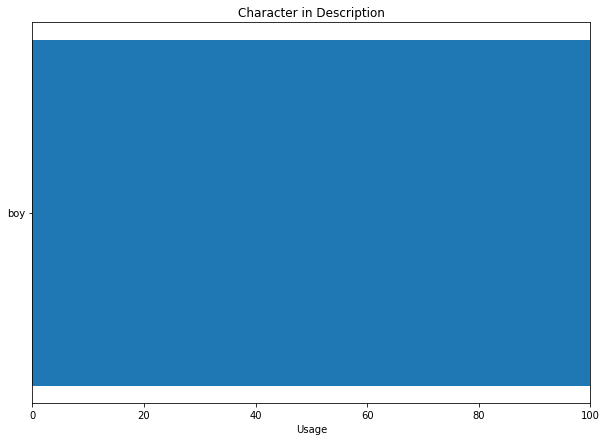

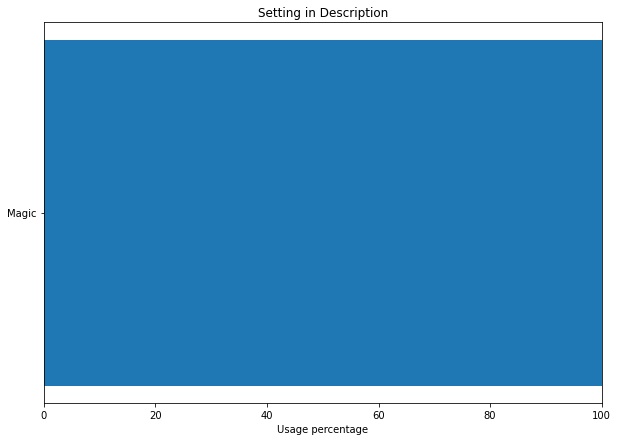

In [21]:
#Plot the results
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

totalChar = 0
for value in CharDescrip:
    totalChar += CharDescrip[value]
if totalChar != 0:
    fraction = 100.0 / totalChar
for value in CharDescrip:
    CharDescrip[value] = CharDescrip[value] * fraction

plt.barh(range(len(CharDescrip)), list(CharDescrip.values()), align='center')
plt.yticks(range(len(CharDescrip)), list(CharDescrip.keys()))
plt.xlim(0, 100)
plt.xlabel('Usage')
plt.title('Character in Description')
plt.show()

totalSettings = 0
for value in SetDescrip:
    totalSettings += SetDescrip[value]
if totalSettings != 0:
    fraction = 100.0 / totalSettings
for value in SetDescrip:
    SetDescrip[value] = SetDescrip[value] * fraction

plt.barh(range(len(SetDescrip)), list(SetDescrip.values()), align='center')
plt.yticks(range(len(SetDescrip)), list(SetDescrip.keys()))
plt.xlim(0, 100)
plt.xlabel('Usage percentage')
plt.title('Setting in Description')
plt.show()
